## Bike Sharing Case study

### Business Understanding
#### Goal : To understand the factors on which demand for bike sharing depends


In [1]:
#importing necessary libraries
import warnings
warnings.filterwarnings(action= "ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px


In [2]:
#reading dataset
bike_df = pd.read_csv("day.csv")
bike_df.head(10)

instant      dteday  season  yr  mnth  holiday  weekday  workingday  \
0        1  01-01-2018       1   0     1        0        1           1   
1        2  02-01-2018       1   0     1        0        2           1   
2        3  03-01-2018       1   0     1        0        3           1   
3        4  04-01-2018       1   0     1        0        4           1   
4        5  05-01-2018       1   0     1        0        5           1   
5        6  06-01-2018       1   0     1        0        6           0   
6        7  07-01-2018       1   0     1        0        0           0   
7        8  08-01-2018       1   0     1        0        1           1   
8        9  09-01-2018       1   0     1        0        2           1   
9       10  10-01-2018       1   0     1        0        3           1   

   weathersit       temp     atemp      hum  windspeed  casual  registered  \
0           2  14.110847  18.18125  80.5833  10.749882     331         654   
1           2  14.902598  17.68695  69.6087  16.652113     131         670   
2           1   8.050924   9.47025  43.7273  16.636703     120        1229   
3           1   8.200000  10.60610  59.0435  10.739832     108        1454   
4           1   9.305237  11.46350  43.6957  12.522300      82        1518   
5           1   8.378268  11.66045  51.8261   6.000868      88        1518   
6           2   8.057402  10.44195  49.8696  11.304642     148        1362   
7           2   6.765000   8.11270  53.5833  17.875868      68         891   
8           1   5.671653   5.80875  43.4167  24.250650      54         768   
9           1   6.184153   7.54440  48.2917  14.958889      41        1280   

    cnt  
0   985  
1   801  
2  1349  
3  1562  
4  1600  
5  1606  
6  1510  
7   959  
8   822  
9  1321

In [3]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


## Data Cleaning

- No null/missing values
- "instant" is unnecessary - can be dropped
- We see that year, month and day are all available as seperate columns, derived from "dteday" column - dropping "dteday"

In [4]:
#dropping instant column
bike_df.drop(["instant","dteday"], axis=1, inplace=True)

In [5]:
# Integer value of season column can be misinterpreted , so changing values to categorical
def seasons(num):
    if num == 1:
        return "spring"
    elif num == 2:
        return "summer"
    elif num == 3:
        return "fall"
    else:
        return "winter"
    
bike_df.season = bike_df.season.apply(func=seasons)

In [6]:
#checking whether apllied values are correct 
bike_df.season.astype("category").value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

In [7]:
bike_df.yr.astype("category").value_counts()

1    365
0    365
Name: yr, dtype: int64

In [8]:
def mnth_map(month):
    return month.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})
bike_df[["mnth"]] = bike_df[["mnth"]].apply(mnth_map)

In [9]:
#checking whether apllied values are correct 
bike_df.mnth.astype("category").value_counts()

Oct    62
May    62
Mar    62
Jul    62
Jan    62
Dec    62
Aug    62
Sep    60
Nov    60
Jun    60
Apr    60
Feb    56
Name: mnth, dtype: int64

In [10]:
bike_df.holiday.astype("category").value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [11]:
def weekday_map(weekday):
    return weekday.map({0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'})
bike_df[["weekday"]] = bike_df[["weekday"]].apply(weekday_map)

In [12]:
#checking whether apllied values are correct 
bike_df.weekday.astype("category").value_counts()

Wed    105
Tue    105
Thu    104
Sun    104
Sat    104
Mon    104
Fri    104
Name: weekday, dtype: int64

In [13]:
bike_df.workingday.astype("category").value_counts()

1    504
0    226
Name: workingday, dtype: int64

In [14]:
def weather_map(weather):
    return weather.map({1:'A',2:'B',3:'C',4:'D'})
bike_df[["weathersit"]] = bike_df[["weathersit"]].apply(weather_map)

In [15]:
#checking whether apllied values are correct 
bike_df.weathersit.astype("category").value_counts()

A    463
B    246
C     21
Name: weathersit, dtype: int64

## Exploratory Data Analysis 

#### Looking at numerical variables

-0.05718748619696199


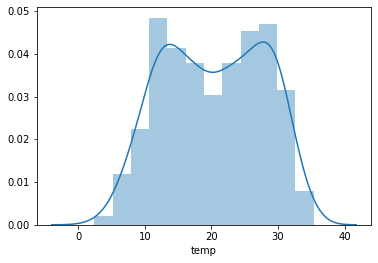

In [16]:
# using distplot to check for skewness
sns.distplot(bike_df.temp)
print(bike_df.temp.skew())

-0.06747586253218554


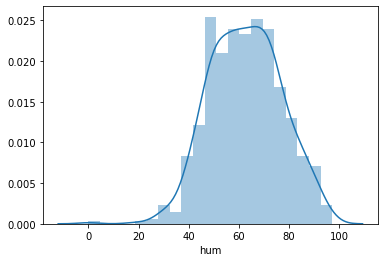

In [17]:
# using distplot to check for skewness
sns.distplot(bike_df.hum)
print(bike_df.hum.skew())

0.6763140387852972


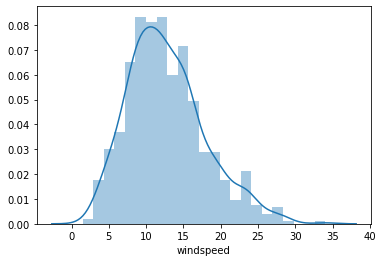

In [18]:
# using distplot to check for skewness
sns.distplot(bike_df.windspeed)
print(bike_df.windspeed.skew())

- We could see that in all above 3 distplots of **temp, hum, windspeed** variables, there is some **skewness** eirther left or right.
- We can do transformation to mitigate the skewness (Ex: Power tranformer from Sklearn)

#### Looking at categorical variables

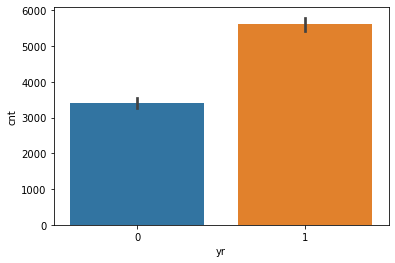

In [19]:
# visualising *cnt* variable with year
sns.barplot(data=bike_df,x="yr", y="cnt")
plt.show()

- **cnt** variable has a significat increase in 2019 compared to 2018

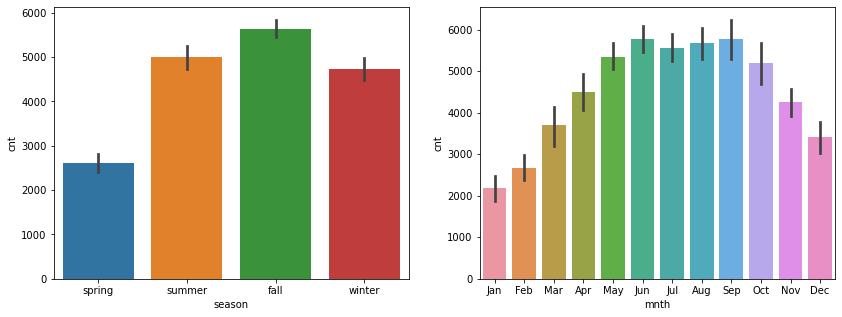

In [20]:
# visualising *cnt* variable with season and months
plt.figure(figsize=(14,5))
plt.subplot(121)
sns.barplot(data=bike_df,x="season", y="cnt")
plt.subplot(122)
sns.barplot(data=bike_df,x="mnth", y="cnt")
plt.show()

- We could see that there is an increasing trend of **cnt** from *spring* to *fall* and then decrease to *winter* and *spring*
- By looking at the monthly trend, there is an increase from **Jan** to **Jun**, slightly fluctuating till **sep** and then decreasing from **Oct** to **Dec**

In [21]:
px.scatter(data_frame=bike_df,x="temp",y="cnt",color="season")

- We observe that **spring** has less temperatures(below 10) and from previous graphs spring has least count of all seasons
- From this we can infer that people are using bikes less in low temperature

### Correlation Matrix


In [22]:
# converting int to float
bike_df[['cnt']]= bike_df[['cnt']].astype('float')
bike_df[['casual']] = bike_df[['casual']].astype('float')
bike_df[['registered']] = bike_df[['registered']].astype('float')

In [23]:
bike_df_numeric = bike_df.select_dtypes(include=['float64'])

In [24]:
bike_df_numeric

temp     atemp      hum  windspeed  casual  registered     cnt
0    14.110847  18.18125  80.5833  10.749882   331.0       654.0   985.0
1    14.902598  17.68695  69.6087  16.652113   131.0       670.0   801.0
2     8.050924   9.47025  43.7273  16.636703   120.0      1229.0  1349.0
3     8.200000  10.60610  59.0435  10.739832   108.0      1454.0  1562.0
4     9.305237  11.46350  43.6957  12.522300    82.0      1518.0  1600.0
..         ...       ...      ...        ...     ...         ...     ...
725  10.420847  11.33210  65.2917  23.458911   247.0      1867.0  2114.0
726  10.386653  12.75230  59.0000  10.416557   644.0      2451.0  3095.0
727  10.386653  12.12000  75.2917   8.333661   159.0      1182.0  1341.0
728  10.489153  11.58500  48.3333  23.500518   364.0      1432.0  1796.0
729   8.849153  11.17435  57.7500  10.374682   439.0      2290.0  2729.0

[730 rows x 7 columns]

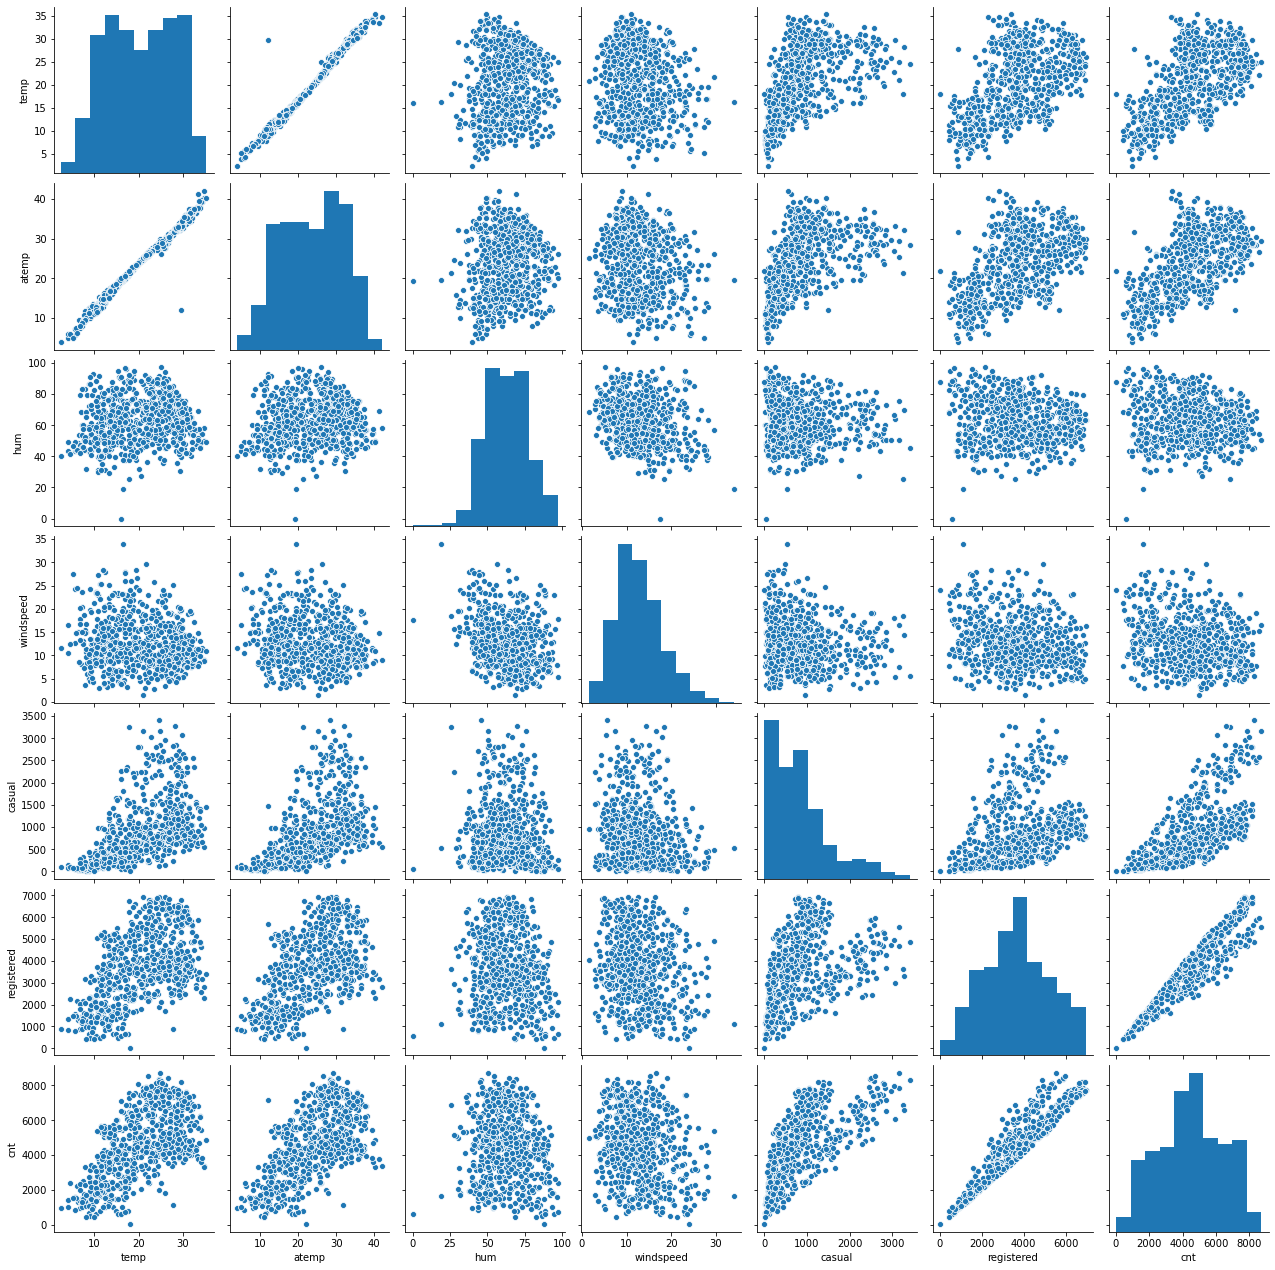

In [25]:
sns.pairplot(bike_df_numeric)
plt.show()

In [26]:
#correlation matrix
corr_mat = bike_df_numeric.corr()
corr_mat

temp     atemp       hum  windspeed    casual  registered  \
temp        1.000000  0.991696  0.128565  -0.158186  0.542731    0.539436   
atemp       0.991696  1.000000  0.141512  -0.183876  0.543362    0.543678   
hum         0.128565  0.141512  1.000000  -0.248506 -0.075211   -0.089212   
windspeed  -0.158186 -0.183876 -0.248506   1.000000 -0.167995   -0.217914   
casual      0.542731  0.543362 -0.075211  -0.167995  1.000000    0.394137   
registered  0.539436  0.543678 -0.089212  -0.217914  0.394137    1.000000   
cnt         0.627044  0.630685 -0.098543  -0.235132  0.672123    0.945411   

                 cnt  
temp        0.627044  
atemp       0.630685  
hum        -0.098543  
windspeed  -0.235132  
casual      0.672123  
registered  0.945411  
cnt         1.000000

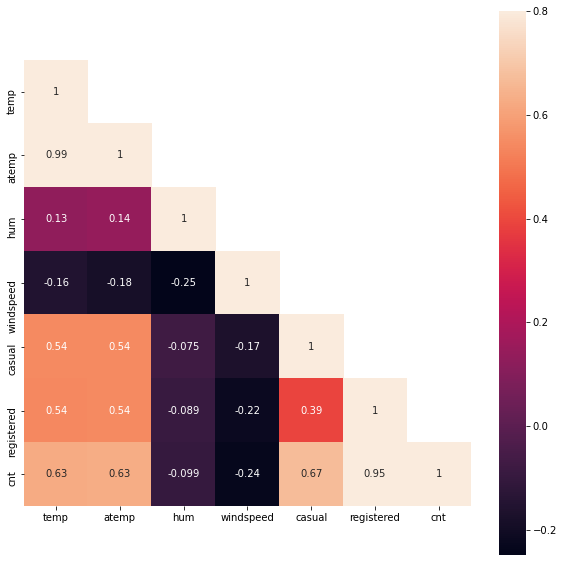

In [27]:
#plotting heatmap to of corr values
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig,ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corr_mat,mask = mask,vmax=0.8,square=True,annot=True)
plt.show()

- **CNT** is highly positively correlated with **causal, registere** variables, followed by **temp & atemp**. We know that cnt is sum of causal and registered , which is why the correlation is too high
-  **temp** and **atemp** are also very high correlated
- **cnt** is negatively correlated with **windspeed**

## Data Preparation

In [28]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  casual      730 non-null    float64
 12  registered  730 non-null    float64
 13  cnt         730 non-null    float64
dtypes: float64(7), int64(3), object(4)
memory usage: 80.0+ KB


In [29]:
#dropping *atemp* as it is highly correlated with *temp
bike_df.drop("atemp", axis=1,inplace=True)

- Variables **season,mnth,weekday and weathersit** have different categorical, we need to conevert these to integer values before modelling

In [30]:
# selecting all categorical variables
bike_df_categorical = bike_df.select_dtypes(include=['object'])

In [31]:
# Creating dummy variables for above mentioned categorical variables
bike_df_dummies = pd.get_dummies(bike_df_categorical,drop_first=True)
bike_df_dummies.head()

season_spring  season_summer  season_winter  mnth_Aug  mnth_Dec  mnth_Feb  \
0              1              0              0         0         0         0   
1              1              0              0         0         0         0   
2              1              0              0         0         0         0   
3              1              0              0         0         0         0   
4              1              0              0         0         0         0   

   mnth_Jan  mnth_Jul  mnth_Jun  mnth_Mar  ...  mnth_Oct  mnth_Sep  \
0         1         0         0         0  ...         0         0   
1         1         0         0         0  ...         0         0   
2         1         0         0         0  ...         0         0   
3         1         0         0         0  ...         0         0   
4         1         0         0         0  ...         0         0   

   weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  weekday_Tue  \
0            0            0            0            0            1   
1            0            0            0            0            0   
2            0            0            0            1            0   
3            0            0            0            0            0   
4            0            1            0            0            0   

   weekday_Wed  weathersit_B  weathersit_C  
0            0             1             0  
1            1             1             0  
2            0             0             0  
3            0             0             0  
4            0             0             0  

[5 rows x 22 columns]

In [32]:
#dropping the categorical values
bike_df = bike_df.drop(list(bike_df_categorical),axis=1)

In [33]:
#concatinating original dataframe and dummy variable
bike_df = pd.concat([bike_df,bike_df_dummies],axis=1)

In [34]:
bike_df.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'casual',
       'registered', 'cnt', 'season_spring', 'season_summer', 'season_winter',
       'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed', 'weathersit_B', 'weathersit_C'],
      dtype='object')

## Model Building

In [35]:
# Splitting data into train and test data
np.random.seed(0)
df_train, df_test = train_test_split(bike_df,train_size = 0.7,test_size = 0.3,random_state = 100)

In [36]:
df_train

yr  holiday  workingday       temp      hum  windspeed  casual  \
653   1        0           1  19.201653  55.8333  12.208807   922.0   
576   1        0           1  29.246653  70.4167  11.083475   968.0   
426   1        0           0  16.980847  62.1250  10.792293   956.0   
728   1        0           1  10.489153  48.3333  23.500518   364.0   
482   1        0           0  15.443347  48.9583   8.708325  1120.0   
..   ..      ...         ...        ...      ...        ...     ...   
526   1        0           1  29.554153  58.7917  13.916771  1017.0   
578   1        0           1  30.852500  65.9583   8.666718   983.0   
53    0        0           1   9.091299  42.3043   6.305571   139.0   
350   0        0           1  10.591653  56.0833  16.292189   275.0   
79    0        0           1  17.647835  73.7391  19.348461   401.0   

     registered     cnt  season_spring  ...  mnth_Oct  mnth_Sep  weekday_Mon  \
653      6612.0  7534.0              0  ...         1         0            0   
576      6248.0  7216.0              0  ...         0         0            0   
426      3110.0  4066.0              1  ...         0         0            1   
728      1432.0  1796.0              1  ...         0         0            0   
482      3100.0  4220.0              0  ...         0         0            1   
..          ...     ...            ...  ...       ...       ...          ...   
526      5647.0  6664.0              0  ...         0         0            0   
578      6278.0  7261.0              0  ...         0         0            0   
53       1778.0  1917.0              1  ...         0         0            0   
350      2464.0  2739.0              0  ...         0         0            0   
79       1676.0  2077.0              0  ...         0         0            0   

     weekday_Sat  weekday_Sun  weekday_Thu  weekday_Tue  weekday_Wed  \
653            0            0            1            0            0   
576            0            0            1            0            0   
426            0            0            0            0            0   
728            0            0            0            1            0   
482            0            0            0            0            0   
..           ...          ...          ...          ...          ...   
526            0            0            0            0            1   
578            1            0            0            0            0   
53             1            0            0            0            0   
350            0            0            0            1            0   
79             0            0            1            0            0   

     weathersit_B  weathersit_C  
653             0             0  
576             0             0  
426             1             0  
728             0             0  
482             1             0  
..            ...           ...  
526             1             0  
578             0             0  
53              0             0  
350             1             0  
79              1             0  

[510 rows x 31 columns]

### Scaling

In [37]:
#using MinMax scale to scale the values
scaler = MinMaxScaler()
var_list = ["temp","hum","windspeed","casual","registered","cnt"]

In [38]:
#fitting values in scaeler
df_train[var_list] = scaler.fit_transform(df_train[var_list])

In [39]:
df_train

yr  holiday  workingday      temp       hum  windspeed    casual  \
653   1        0           1  0.509887  0.575354   0.300794  0.280402   
576   1        0           1  0.815169  0.725633   0.264686  0.294422   
426   1        0           0  0.442393  0.640189   0.255342  0.290765   
728   1        0           1  0.245101  0.498067   0.663106  0.110332   
482   1        0           0  0.395666  0.504508   0.188475  0.340750   
..   ..      ...         ...       ...       ...        ...       ...   
526   1        0           1  0.824514  0.605840   0.355596  0.309357   
578   1        0           1  0.863973  0.679690   0.187140  0.298994   
53    0        0           1  0.202618  0.435939   0.111379  0.041756   
350   0        0           1  0.248216  0.577930   0.431816  0.083206   
79    0        0           1  0.462664  0.759870   0.529881  0.121609   

     registered       cnt  season_spring  ...  mnth_Oct  mnth_Sep  \
653    0.951776  0.864243              0  ...         1         0   
576    0.899220  0.827658              0  ...         0         0   
426    0.446145  0.465255              1  ...         0         0   
728    0.203869  0.204096              1  ...         0         0   
482    0.444701  0.482973              0  ...         0         0   
..          ...       ...            ...  ...       ...       ...   
526    0.812446  0.764151              0  ...         0         0   
578    0.903552  0.832835              0  ...         0         0   
53     0.253826  0.218017              1  ...         0         0   
350    0.352873  0.312586              0  ...         0         0   
79     0.239099  0.236424              0  ...         0         0   

     weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  weekday_Tue  \
653            0            0            0            1            0   
576            0            0            0            1            0   
426            1            0            0            0            0   
728            0            0            0            0            1   
482            1            0            0            0            0   
..           ...          ...          ...          ...          ...   
526            0            0            0            0            0   
578            0            1            0            0            0   
53             0            1            0            0            0   
350            0            0            0            0            1   
79             0            0            0            1            0   

     weekday_Wed  weathersit_B  weathersit_C  
653            0             0             0  
576            0             0             0  
426            0             1             0  
728            0             0             0  
482            0             1             0  
..           ...           ...           ...  
526            1             1             0  
578            0             0             0  
53             0             0             0  
350            0             1             0  
79             0             1             0  

[510 rows x 31 columns]

#### Dividing into X and Y sets

In [40]:
#Dividing training data into X and Y sets
y_train = df_train.pop('cnt')
X_train = df_train.drop(['casual','registered'],axis=1)

In [41]:
#Adding a constant and fitting data into model
X_train_sm = sm.add_constant(X_train)

lr = sm.OLS(y_train,X_train_sm).fit()

In [42]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     98.04
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          4.33e-179
Time:                        21:36:36   Log-Likelihood:                 523.81
No. Observations:                 510   AIC:                            -989.6
Df Residuals:                     481   BIC:                            -866.8
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3984      0.085      4.683      0.000       0.231       0.566
yr                0.2309      0.008     28.387      0.000       0.215       0.247
holiday          -0.1354      0.065     -2.072      0.039      -0.264      -0.007
workingday       -0.0605      0.071     -0.852      0.395      -0.200       0.079
temp              0.4455      0.047      9.513      0.000       0.353       0.537
hum              -0.1573      0.039     -4.049      0.000      -0.234      -0.081
windspeed        -0.1830      0.026     -7.036      0.000      -0.234      -0.132
season_spring    -0.0437      0.030     -1.444      0.149      -0.103       0.016
season_summer     0.0422      0.026      1.598      0.111      -0.010       0.094
season_winter     0.1109      0.028      3.938      0.000       0.056       0.166
mnth_Aug          0.0215      0.034      0.632      0.527      -0.045       0.088
mnth_Dec         -0.0457      0.034     -1.348      0.178      -0.112       0.021
mnth_Feb         -0.0373      0.033     -1.121      0.263      -0.103       0.028
mnth_Jan         -0.0636      0.034     -1.880      0.061      -0.130       0.003
mnth_Jul         -0.0349      0.035     -0.985      0.325      -0.105       0.035
mnth_Jun          0.0010      0.025      0.038      0.969      -0.049       0.051
mnth_Mar          0.0006      0.025      0.025      0.980      -0.048       0.049
mnth_May          0.0241      0.021      1.134      0.257      -0.018       0.066
mnth_Nov         -0.0416      0.037     -1.133      0.258      -0.114       0.031
mnth_Oct          0.0058      0.036      0.160      0.873      -0.065       0.077
mnth_Sep          0.0861      0.032      2.667      0.008       0.023       0.149
weekday_Mon      -0.0538      0.072     -0.751      0.453      -0.195       0.087
weekday_Sat      -0.0039      0.015     -0.258      0.796      -0.033       0.026
weekday_Sun      -0.0602      0.072     -0.839      0.402      -0.201       0.081
weekday_Thu      -0.0151      0.015     -0.980      0.327      -0.045       0.015
weekday_Tue      -0.0285      0.015     -1.933      0.054      -0.057       0.000
weekday_Wed      -0.0302      0.015     -2.049      0.041      -0.059      -0.001
weathersit_B     -0.0594      0.011     -5.637      0.000      -0.080      -0.039
weathersit_C     -0.2515      0.027     -9.455      0.000      -0.304      -0.199
==============================================================================
Omnibus:                       78.889   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.035
Skew:                          -0.768   Prob(JB):                     4.06e-46
Kurtosis:                       5.735   Cond. No.                         70.5
================================================================

- For a model with all the variables, we have a got a R-squared value as 0.851 and Adjusted R-squared as 0.842.
- But, whether all the variables are statistically significant?
    - NO. If we see p-values of month and weekday dummy variables, most of them have high p-values , which indicates that they are statistically insignificant

#### Using RFE technique to select top variables

In [43]:
#RFE with 15 feature
lm = LinearRegression()
rfe_1 = RFE(lm,15)

#fit with 15 features
rfe_1.fit(X_train,y_train)

RFE(estimator=LinearRegression(), n_features_to_select=15)

In [44]:
print(rfe_1.support_)
print(rfe_1.ranking_)

[ True  True False  True  True  True  True  True  True False  True False
  True  True False False False  True False  True False False False False
 False False  True  True]
[ 1  1  3  1  1  1  1  1  1  9  1  2  1  1 13 14  6  1 11  1  5 12  4 10
  8  7  1  1]


##### Evaluation of model with 15 features

In [45]:
#subset featues selected by RFE1
cols = X_train.columns[rfe_1.support_]

#subset of training data with 15 selected columns
X_train_mod1 = X_train[cols]

#Add constant 
X_train_mod1 = sm.add_constant(X_train_mod1)
X_train_mod1.head()

const  yr  holiday      temp       hum  windspeed  season_spring  \
653    1.0   1        0  0.509887  0.575354   0.300794              0   
576    1.0   1        0  0.815169  0.725633   0.264686              0   
426    1.0   1        0  0.442393  0.640189   0.255342              1   
728    1.0   1        0  0.245101  0.498067   0.663106              1   
482    1.0   1        0  0.395666  0.504508   0.188475              0   

     season_summer  season_winter  mnth_Dec  mnth_Jan  mnth_Jul  mnth_Nov  \
653              0              1         0         0         0         0   
576              0              0         0         0         1         0   
426              0              0         0         0         0         0   
728              0              0         1         0         0         0   
482              1              0         0         0         0         0   

     mnth_Sep  weathersit_B  weathersit_C  
653         0             0             0  
576         0             0             0  
426         0             1             0  
728         0             0             0  
482         0             1             0

In [46]:
#Fitting the model with 15 features and looking at the summary
model1 = sm.OLS(y_train,X_train_mod1).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.2
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          3.34e-189
Time:                        21:36:36   Log-Likelihood:                 514.72
No. Observations:                 510   AIC:                            -997.4
Df Residuals:                     494   BIC:                            -929.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3202      0.036      8.886

- We could see that our model has good Rsquared value L: 0.845 and Adjusted R-squared value: 0.841
- Also, we have P values with in limits ( < 0.05)
- But, let us check for multicollinearity by calculating VIF values

In [47]:
temp = X_train_mod1.drop('const',axis=1)

In [48]:
#create a dataframe with all the feature variables and their respective VIFs except constant 
vif = pd.DataFrame()
vif['features'] = temp.columns
vif['VIF'] = [variance_inflation_factor(temp.values,i) for i in range(temp.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

features    VIF
3             hum  30.94
2            temp  17.80
4       windspeed   4.72
5   season_spring   4.37
7   season_winter   4.06
6   season_summer   2.81
13   weathersit_B   2.32
0              yr   2.09
11       mnth_Nov   1.83
9        mnth_Jan   1.75
10       mnth_Jul   1.59
8        mnth_Dec   1.55
12       mnth_Sep   1.41
14   weathersit_C   1.28
1         holiday   1.06

- As **hum** variable has very high VIF value, let's remove it and model again

### Model 2

In [49]:
#dropping hum feature
X_train_mod2 = X_train_mod1.drop('hum',axis=1)

#Add constant 
X_train_mod2 = sm.add_constant(X_train_mod2)
X_train_mod2.head()

const  yr  holiday      temp  windspeed  season_spring  season_summer  \
653    1.0   1        0  0.509887   0.300794              0              0   
576    1.0   1        0  0.815169   0.264686              0              0   
426    1.0   1        0  0.442393   0.255342              1              0   
728    1.0   1        0  0.245101   0.663106              1              0   
482    1.0   1        0  0.395666   0.188475              0              1   

     season_winter  mnth_Dec  mnth_Jan  mnth_Jul  mnth_Nov  mnth_Sep  \
653              1         0         0         0         0         0   
576              0         0         0         1         0         0   
426              0         0         0         0         0         0   
728              0         1         0         0         0         0   
482              0         0         0         0         0         0   

     weathersit_B  weathersit_C  
653             0             0  
576             0             0  
426             1             0  
728             0             0  
482             1             0

In [50]:
#Fitting the model with 15 features and looking at the summary
model2 = sm.OLS(y_train,X_train_mod2).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     185.4
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          1.57e-186
Time:                        21:36:37   Log-Likelihood:                 505.61
No. Observations:                 510   AIC:                            -981.2
Df Residuals:                     495   BIC:                            -917.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2466      0.032      7.679

- Very High VIF indicates multicollinearity. After dropping hum feature, there is no considerable decrease in R-squared or Adjusted R-squared
- Let's calculate the VIF values again and check for high VIF features

In [51]:
#create a dataframe with all the feature variables and their respective VIFs except constant 
temp = X_train_mod2.drop('const',axis=1)
vif = pd.DataFrame()
vif['features'] = temp.columns
vif['VIF'] = [variance_inflation_factor(temp.values,i) for i in range(temp.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

features   VIF
2            temp  5.17
3       windspeed  4.67
6   season_winter  2.94
4   season_spring  2.89
5   season_summer  2.23
0              yr  2.07
10       mnth_Nov  1.80
8        mnth_Jan  1.66
9        mnth_Jul  1.59
12   weathersit_B  1.56
7        mnth_Dec  1.46
11       mnth_Sep  1.35
13   weathersit_C  1.09
1         holiday  1.06

- Let's drop **temp** variable as well and model again

### Model 3

In [52]:
#dropping hum feature
X_train_mod3 = X_train_mod2.drop('temp',axis=1)

#Add constant 
X_train_mod3 = sm.add_constant(X_train_mod3)
X_train_mod3.head()

const  yr  holiday  windspeed  season_spring  season_summer  \
653    1.0   1        0   0.300794              0              0   
576    1.0   1        0   0.264686              0              0   
426    1.0   1        0   0.255342              1              0   
728    1.0   1        0   0.663106              1              0   
482    1.0   1        0   0.188475              0              1   

     season_winter  mnth_Dec  mnth_Jan  mnth_Jul  mnth_Nov  mnth_Sep  \
653              1         0         0         0         0         0   
576              0         0         0         1         0         0   
426              0         0         0         0         0         0   
728              0         1         0         0         0         0   
482              0         0         0         0         0         0   

     weathersit_B  weathersit_C  
653             0             0  
576             0             0  
426             1             0  
728             0             0  
482             1             0

In [53]:
#Fitting the model with 15 features and looking at the summary
model3 = sm.OLS(y_train,X_train_mod3).fit()
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     145.8
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          5.50e-160
Time:                        21:36:37   Log-Likelihood:                 439.69
No. Observations:                 510   AIC:                            -851.4
Df Residuals:                     496   BIC:                            -792.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5961      0.016     37.557

- R squared decreased to 0.793 and Adjusted R-squared to 0.787
- P-value of mnth_Jul and season_winter increased.
- Let's drop mnth_Jul and model again

### Model 4

In [54]:
#dropping hum feature
X_train_mod4 = X_train_mod3.drop('mnth_Jul',axis=1)

#Add constant 
X_train_mod4 = sm.add_constant(X_train_mod4)
X_train_mod4.head()

const  yr  holiday  windspeed  season_spring  season_summer  \
653    1.0   1        0   0.300794              0              0   
576    1.0   1        0   0.264686              0              0   
426    1.0   1        0   0.255342              1              0   
728    1.0   1        0   0.663106              1              0   
482    1.0   1        0   0.188475              0              1   

     season_winter  mnth_Dec  mnth_Jan  mnth_Nov  mnth_Sep  weathersit_B  \
653              1         0         0         0         0             0   
576              0         0         0         0         0             0   
426              0         0         0         0         0             1   
728              0         1         0         0         0             0   
482              0         0         0         0         0             1   

     weathersit_C  
653             0  
576             0  
426             0  
728             0  
482             0

In [55]:
#Fitting the model with 15 features and looking at the summary
model4 = sm.OLS(y_train,X_train_mod4).fit()
print(model4.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     158.0
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          6.36e-161
Time:                        21:36:37   Log-Likelihood:                 439.28
No. Observations:                 510   AIC:                            -852.6
Df Residuals:                     497   BIC:                            -797.5
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5892      0.014     42.571

#### Calculating VIF again

In [56]:
#create a dataframe with all the feature variables and their respective VIFs except constant 
temp = X_train_mod4.drop('const',axis=1)
vif = pd.DataFrame()
vif['features'] = temp.columns
vif['VIF'] = [variance_inflation_factor(temp.values,i) for i in range(temp.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

features   VIF
2       windspeed  3.52
5   season_winter  2.74
3   season_spring  2.71
4   season_summer  1.86
8        mnth_Nov  1.79
0              yr  1.77
7        mnth_Jan  1.64
10   weathersit_B  1.52
6        mnth_Dec  1.45
9        mnth_Sep  1.16
11   weathersit_C  1.09
1         holiday  1.06

- Model 4 gave R-squared : 0.792 and Adjusted R-squared : 0.787
- VIFs are all within limt, but P- value of season_winter is high
- Lets drop season_winter and model again

### Model 5

In [57]:
#dropping hum feature
X_train_mod5 = X_train_mod4.drop('season_winter',axis=1)

#Add constant 
X_train_mod5 = sm.add_constant(X_train_mod5)
X_train_mod5.head()

const  yr  holiday  windspeed  season_spring  season_summer  mnth_Dec  \
653    1.0   1        0   0.300794              0              0         0   
576    1.0   1        0   0.264686              0              0         0   
426    1.0   1        0   0.255342              1              0         0   
728    1.0   1        0   0.663106              1              0         1   
482    1.0   1        0   0.188475              0              1         0   

     mnth_Jan  mnth_Nov  mnth_Sep  weathersit_B  weathersit_C  
653         0         0         0             0             0  
576         0         0         0             0             0  
426         0         0         0             1             0  
728         0         0         0             0             0  
482         0         0         0             1             0

In [58]:
#Fitting the model with 15 features and looking at the summary
model5 = sm.OLS(y_train,X_train_mod5).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     172.3
Date:                Mon, 05 Oct 2020   Prob (F-statistic):          7.42e-162
Time:                        21:36:37   Log-Likelihood:                 438.82
No. Observations:                 510   AIC:                            -853.6
Df Residuals:                     498   BIC:                            -802.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5845      0.013     45.172

In [59]:
#create a dataframe with all the feature variables and their respective VIFs except constant 
temp = X_train_mod5.drop('const',axis=1)
vif = pd.DataFrame()
vif['features'] = temp.columns
vif['VIF'] = [variance_inflation_factor(temp.values,i) for i in range(temp.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by='VIF',ascending=False)
vif

features   VIF
2       windspeed  3.22
3   season_spring  2.36
0              yr  1.74
4   season_summer  1.69
6        mnth_Jan  1.62
9    weathersit_B  1.47
7        mnth_Nov  1.23
8        mnth_Sep  1.16
5        mnth_Dec  1.13
1         holiday  1.06
10   weathersit_C  1.06

- Model5 has R squared : 0.792 and Adjusted R-squared : 0.787
- P-values and VIFs are all within limits
- We have 11 features now and good R squared and Adjusted R-squared scores

## Residual analysis of train data

In [60]:
y_train_cnt = model5.predict(X_train_mod5)

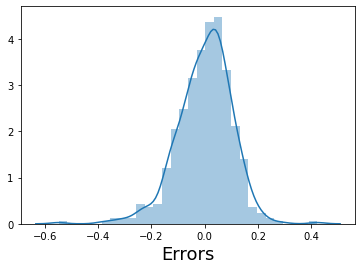

In [61]:
res = y_train - y_train_cnt
plt.figure()
sns.distplot(res,bins = 30)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.show()

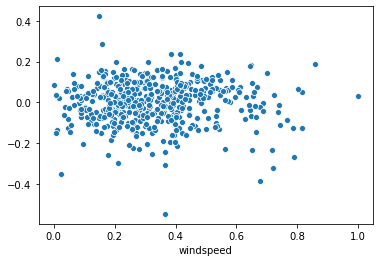

In [62]:
sns.scatterplot(X_train.windspeed, res)
plt.show()

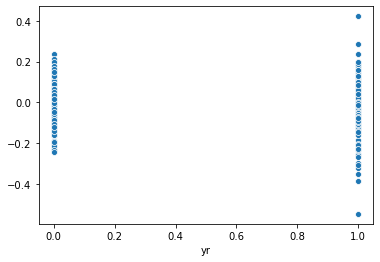

In [63]:
sns.scatterplot(X_train.yr, res)
plt.show()

- We could see no patterns in the error terms, they are random
- We see that varaince of the error terms is also constant.

## Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fifth model.

#### Applying scales on test data

In [64]:
#using MinMax scale to scale the values
var_list = ["temp","hum","windspeed","casual","registered","cnt"]

In [65]:
#fitting values in scaeler
df_test[var_list] = scaler.transform(df_test[var_list])

In [66]:
df_test.describe()

yr     holiday  workingday        temp         hum   windspeed  \
count  219.000000  219.000000  219.000000  219.000000  219.000000  219.000000   
mean     0.479452    0.036530    0.639269    0.558941    0.638508    0.313350   
std      0.500722    0.188034    0.481313    0.233698    0.148974    0.159947   
min      0.000000    0.000000    0.000000    0.046591    0.261915   -0.042808   
25%      0.000000    0.000000    0.000000    0.354650    0.527265    0.198517   
50%      0.000000    0.000000    1.000000    0.558691    0.627737    0.299459   
75%      1.000000    0.000000    1.000000    0.759096    0.743928    0.403048   
max      1.000000    1.000000    1.000000    0.984424    1.002146    0.807474   

           casual  registered         cnt  season_spring  ...    mnth_Oct  \
count  219.000000  219.000000  219.000000     219.000000  ...  219.000000   
mean     0.266372    0.527146    0.520592       0.255708  ...    0.082192   
std      0.217246    0.217921    0.218435       0.437258  ...    0.275286   
min      0.002133    0.059486    0.048205       0.000000  ...    0.000000   
25%      0.101951    0.359154    0.377531       0.000000  ...    0.000000   
50%      0.223712    0.526567    0.524275       0.000000  ...    0.000000   
75%      0.362085    0.664742    0.672745       1.000000  ...    0.000000   
max      1.038708    0.985273    0.963300       1.000000  ...    1.000000   

         mnth_Sep  weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  \
count  219.000000   219.000000   219.000000   219.000000   219.000000   
mean     0.086758     0.155251     0.132420     0.173516     0.155251   
std      0.282125     0.362974     0.339723     0.379560     0.362974   
min      0.000000     0.000000     0.000000     0.000000     0.000000   
25%      0.000000     0.000000     0.000000     0.000000     0.000000   
50%      0.000000     0.000000     0.000000     0.000000     0.000000   
75%      0.000000     0.000000     0.000000     0.000000     0.000000   
max      1.000000     1.000000     1.000000     1.000000     1.000000   

       weekday_Tue  weekday_Wed  weathersit_B  weathersit_C  
count   219.000000   219.000000    219.000000    219.000000  
mean      0.118721     0.123288      0.319635      0.027397  
std       0.324202     0.329520      0.467403      0.163612  
min       0.000000     0.000000      0.000000      0.000000  
25%       0.000000     0.000000      0.000000      0.000000  
50%       0.000000     0.000000      0.000000      0.000000  
75%       0.000000     0.000000      1.000000      0.000000  
max       1.000000     1.000000      1.000000      1.000000  

[8 rows x 31 columns]

#### Dividing into X_test and y_test

In [67]:
y_test = df_test.pop('cnt')
X_test = df_test

In [68]:
X_test

yr  holiday  workingday      temp       hum  windspeed    casual  \
184   0        1           0  0.831783  0.657364   0.084219  0.933557   
535   1        0           1  0.901354  0.610133   0.153728  0.265163   
299   0        0           0  0.511964  0.837699   0.334206  0.072539   
221   0        0           1  0.881625  0.437098   0.339570  0.268820   
152   0        0           0  0.817246  0.314298   0.537414  0.223712   
..   ..      ...         ...       ...       ...        ...       ...   
400   1        0           1  0.257562  0.708888   0.287411  0.096312   
702   1        0           1  0.519232  0.756118   0.283397  0.167327   
127   0        0           1  0.584649  0.650923   0.069510  0.426394   
640   1        0           1  0.745598  0.817947   0.052115  0.221274   
72    0        0           1  0.331557  0.512107   0.203418  0.108808   

     registered  season_spring  season_summer  ...  mnth_Oct  mnth_Sep  \
184    0.427086              0              0  ...         0         0   
535    0.767976              0              1  ...         0         0   
299    0.346376              0              0  ...         1         0   
221    0.559630              0              0  ...         0         0   
152    0.608143              0              1  ...         0         0   
..          ...            ...            ...  ...       ...       ...   
400    0.376697              1              0  ...         0         0   
702    0.871354              0              0  ...         0         0   
127    0.420445              0              1  ...         0         0   
640    0.985273              0              0  ...         1         0   
72     0.240687              1              0  ...         0         0   

     weekday_Mon  weekday_Sat  weekday_Sun  weekday_Thu  weekday_Tue  \
184            0            0            0            1            0   
535            0            0            0            0            0   
299            0            0            1            0            0   
221            0            1            0            0            0   
152            0            0            1            0            0   
..           ...          ...          ...          ...          ...   
400            0            0            0            0            0   
702            0            0            0            1            0   
127            0            0            0            0            0   
640            0            0            0            0            0   
72             0            0            0            1            0   

     weekday_Wed  weathersit_B  weathersit_C  
184            0             1             0  
535            0             0             0  
299            0             1             0  
221            0             0             0  
152            0             0             0  
..           ...           ...           ...  
400            1             1             0  
702            0             0             0  
127            1             0             0  
640            0             1             0  
72             0             0             0  

[219 rows x 30 columns]

In [69]:
# Adding constant variable to test dataframe
X_test_mod5 = sm.add_constant(X_test)

In [70]:
# Creating X_test_mod5 dataframe by dropping variables from X_test_mod5

X_test_mod5 = X_test_mod5[X_train_mod5.columns]

In [71]:
y_pred_mod5  = model5.predict(X_test_mod5)

## Model Evaluation

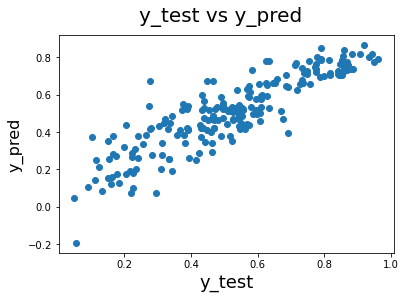

In [72]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_pred_mod5)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)     
plt.show()

In [73]:
mse = mean_squared_error(y_test, y_pred_mod5)
r_squared = r2_score(y_test, y_pred_mod5)

In [74]:
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.010582008624694286
r_square_value : 0.7772012091843699


- R-squared value on **train** dataset for our final model (model5) is : 0.792
- R-squared value on **test** dataset : 0.777

Overall we have a decent model, but we also acknowledge that we could do better. 

We can explore more options:
1. Add new features 
2. Build a non-linear model
3. Handle skewness in the data using Transformation